This notebook is aimed at looked at the allele analysis output a bit more interms of what are the alleles. What is missing? What is the GO term enrichment in those if any? How much are effectors?....

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [27]:
pwh_set = []
def pwh_filter (q_contig, pwh_set=pwh_set):
    '''Checks if contig belongs to the primary with haplotig set.'''
    if q_contig in pwh_set:
        return True
    else:
        return False

In [30]:
def on_primary_contig (q_contig):
    '''Quick function that checks if query is on primary contig or not'''
    if q_contig.startswith('hcontig'):
        return False
    elif q_contig.startswith('pcontig'):
        return True
    else:
        print('Contig annotation needs to start with hcontig or pcontig')

In [3]:
#Define the PATH
BASE_AA_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12'
BASE_A_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
BLAST_RESULT_PATH = os.path.join(BASE_AA_PATH,'allele_analysis' )
ALLELE_PATH =os.path.join(BASE_AA_PATH ,'allele_analysis/alleles_proteinortho')
ALLELE_QC_PATH = os.path.join(BASE_AA_PATH, 'allele_analysis', 'no_alleles_proteinortho_QC_Qcov80_PctID70')
LIST_PATH = os.path.join(BASE_AA_PATH, 'enrichment_analysis', 'lists')
OUT_PATH = os.path.join(BASE_AA_PATH, 'post_allele_analysis')
if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

In [4]:
#define some input files an make allele dataframe
allele_header = ['p_gene', 'h_gene']
a_overlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_overlap_df['Linkage'] = 'h_contig_overlap'
a_no_roverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_roverlap_df['Linkage'] = 'no_r_overlap'
a_no_soverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_specific_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_soverlap_df['Linkage'] = 'no_s_overlap'
allele_df = pd.concat([a_overlap_df, a_no_roverlap_df, a_no_soverlap_df], axis=0)

In [5]:
#define some input files and get no allele dataframe
no_allele_df = pd.read_csv(os.path.join(ALLELE_QC_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_postQC.txt')\
                          ,header=None, names=['gene'])

In [6]:
#get the blast dataframe and the QC dataframe
allele_blast_df = pd.read_csv(os.path.join(BLAST_RESULT_PATH, 'Pst_104E_v12_p_ctg.Pst_104E_v12_h_ctg.0.001.blastp.outfmt6.allele_analysis'), sep='\t')
allele_QC_df = pd.read_csv(os.path.join(ALLELE_QC_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_QC.Qcov80.PctID70.df'), sep='\t')

/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#now read in some types of genes
gene_group_list = ['BUSCOS', 'EFFECTORS', 'HAUSTORIA', 'EFFECTORP']
p_gene_dict = {}
h_gene_dict = {}
p_gene_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_busco.list')\
                                    , header=None)[0].tolist()
p_gene_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effector.list')\
                                    , header=None)[0].tolist()
p_gene_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_cluster_8.list')\
                                    , header=None)[0].tolist()
p_gene_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effectorp.list')\
                                    , header=None)[0].tolist()
h_gene_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_busco.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effector.list')\
                                    , header=None)[0].tolist()
h_gene_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_cluster_15.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effectorp.list')\
                                    , header=None)[0].tolist()
#now get pwh and pwoh
pwh_list = pd.read_csv(os.path.join(BASE_A_PATH, 'Pst_104E_v12_pwh.txt')\
                                , header=None)[0].tolist()
pwoh_list = pd.read_csv(os.path.join(BASE_A_PATH, 'Pst_104E_v12_pwoh.txt')\
                                , header=None)[0].tolist()

In [8]:
#cause we are a bit lazy an like notebooks here we go looking for stuff
os.chdir(BASE_A_PATH)
print("Effectors on pwh contigs")
!cat Pst_104E_v12_pwh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_effector.gene.gff3 | wc -l 

Effectors on pwh contigs
1523


In [9]:
print("Effectors on pwoh contigs")
!cat Pst_104E_v12_pwoh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_effector.gene.gff3 | wc -l 

Effectors on pwoh contigs
49


In [10]:
print("BUSCOS on pwoh contigs")
!cat Pst_104E_v12_pwoh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_busco.gene.gff3 | wc -l 

BUSCOS on pwoh contigs
49


In [11]:
print("BUSCOS on pwh contigs")
!cat Pst_104E_v12_pwh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_busco.gene.gff3 | wc -l 

BUSCOS on pwh contigs
1395


In [12]:
print("BUSCOS on hcontigs")
!wc -l {LIST_PATH}/Pst_104E_v12_h_busco.gene.gff3

BUSCOS on hcontigs
1293 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_h_busco.gene.gff3


In [91]:
#now see if there is an enrichment in GO terms associated with alleles
def orphan_analysis(_orphan_list):
    orphan_effectors = 0
    orphan_effectors_h = 0
    orphan_effectors_pwh = 0
    orphan_effectors_pwoh =0
    orphan_busco = 0
    orphan_busco_h = 0
    orphan_busco_pwh = 0
    orphan_busco_pwoh = 0
    for x in _orphan_list:
        if x in p_gene_dict['BUSCOS']:
            contig = re.search(r'[hp][^.]*',x).group()
            if pwh_filter(contig, pwh_list) == True:
                orphan_busco_pwh += 1
            else:
                orphan_busco_pwoh += 1
        if x in h_gene_dict['BUSCOS']:
            orphan_busco_h += 1
        #now same for effectors    
        if x in p_gene_dict['EFFECTORS']:
            contig = re.search(r'[hp][^.]*',x).group()
            if pwh_filter(contig, pwh_list) == True:
                orphan_effectors_pwh += 1
            else:
                orphan_effectors_pwoh += 1
            
        if x in h_gene_dict['EFFECTORS']:
            orphan_effectors_h += 1      
    orphan_effectors = orphan_effectors_h + orphan_effectors_pwh + orphan_effectors_pwoh
    orphan_busco = orphan_busco_h +  orphan_busco_pwh +  orphan_busco_pwoh
    print('Out of %i orphan genes we have %i orphan buscos and %i orphan effectors.'\
          %(len(_orphan_list), orphan_busco, orphan_effectors))
    print('On haplotigs. Out of %i orphan genes we have %i orphan buscos and %i orphan effectors.'\
         %(len([x for x in _orphan_list if 'hcontig' in x]), orphan_busco_h, orphan_effectors_h))
    print('On pwh. Out of %i orphan genes we have %i orphan buscos and %i orphan effectors.'\
         %([pwh_filter(re.search(r'[hp][^.]*',x).group(), pwh_list) for x in _orphan_list].count(True), orphan_busco_pwh, orphan_effectors_pwh))
    print('On pwoh. Out of %i orphan genes we have %i orphan buscos and %i orphan effectors.'\
         %([pwh_filter(re.search(r'[hp][^.]*',x).group(), pwh_list) for x in _orphan_list if 'pcontig' in x].count(False), orphan_busco_pwoh, orphan_effectors_pwoh))

In [92]:
orphan_analysis(no_allele_df.gene)

Out of 894 orphan genes we have 83 orphan buscos and 30 orphan effectors.
On haplotigs. Out of 169 orphan genes we have 4 orphan buscos and 4 orphan effectors.
On pwh. Out of 640 orphan genes we have 65 orphan buscos and 25 orphan effectors.
On pwoh. Out of 85 orphan genes we have 14 orphan buscos and 1 orphan effectors.


In [25]:
no_allele_df['contig'] = no_allele_df.gene.str.extract(r'([hp][^.]*)')

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [28]:
no_allele_df['pwh'] = no_allele_df.contig.apply(lambda x: pwh_filter(x, pwh_list))

In [31]:
no_allele_df['pcontig'] = no_allele_df.contig.apply(lambda x: on_primary_contig(x))

In [34]:
#no alleles on pwoh
(no_allele_df.pwh == True).sum()

640

In [35]:
((no_allele_df.pwh == False) & (no_allele_df.pcontig == True)).sum()

85

In [36]:
((no_allele_df.pwh == False) & (no_allele_df.pcontig == False)).sum()

169

In [38]:
#now do some more filtering and see what is happening
allele_QC_df.columns

Index(['Query', 'Target', 'PctID', 'AlnLgth', 'NumMis', 'NumGap', 'StartQuery',
       'StopQuery', 'StartTarget', 'StopTarget', 'e-value', 'BitScore',
       'QLgth', 'QCov', 'q_contig', 't_contig', 'q_contig == t_contig',
       'primary_contig', 'pwh_contig', 'gene_on_genome_blast_hit',
       'exn_asso_contig', 'exn_no_asso_contig', 'ph_p_homo_region',
       'Pst_E104_v1_ph_ctg.freebayes_SNP',
       'Pst_E104_v1_ph_ctg.freebayes_SNP_#',
       'Pst_E104_v1_ph_ctg.freebayes_SNP_%', 'overlap_p_on_h_mapping'],
      dtype='object')

In [100]:
#set the coverage limits
QCov_limit = 70
PctID_limit = 80
#now get all the ids for which we have hits above the cut off
tmp_df = allele_QC_df[allele_QC_df.Target != 'False'] #filter out no hits
tmp_df[['QCov', 'PctID']] = tmp_df[['QCov', 'PctID']].apply(pd.to_numeric) #make numeric
#get ids of stuff above the cut off
tmp_df_ids = tmp_df[(tmp_df.QCov >= QCov_limit) & (tmp_df.PctID >= PctID_limit)]['Query'].unique()
#filter those out
tmp_df = tmp_df[~tmp_df.Query.isin(tmp_df_ids)]

/home/benjamin/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [155]:
#now filter dataframe on different other issues
out_filter = (tmp_df.exn_asso_contig != True) & (tmp_df.exn_no_asso_contig != True) & \
            (tmp_df.ph_p_homo_region != True)
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
orphan_analysis(queries_out_filtered)
#now print this out again into the ALLELE_QC folder
fn_short = 'Pst_104E_v12_ph_ctg.no_alleles_postQC.PctID%i_QCov%i.no_exonerate.txt' % (PctID_limit, QCov_limit)
fn_short_p = 'Pst_104E_v12_p_ctg.orphan.PctID%i_QCov%i.no_exonerate.list' % (PctID_limit, QCov_limit)
fn_short_h = 'Pst_104E_v12_h_ctg.orphan.PctID%i_QCov%i.no_exonerate.list' % (PctID_limit, QCov_limit)
fn = os.path.join(ALLELE_QC_PATH, fn_short)
fn_list_h = os.path.join(LIST_PATH, fn_short_h)
fn_list_p = os.path.join(LIST_PATH, fn_short_p)
fh_list_p = open(fn_list_p, 'w')
fh_list_h = open(fn_list_h, 'w')
fh = open(fn, 'w')
for gene in queries_out_filtered:
    if 'pcontig' in gene:
        print(gene, file=fh_list_p)
    if 'hcontig' in gene:
        print(gene, file=fh_list_h)
    print(gene, file=fh)
fh.close()
fh_list_p.close()
fh_list_h.close()

Out of 2749 orphan genes we have 116 orphan buscos and 224 orphan effectors.
On haplotigs. Out of 945 orphan genes we have 31 orphan buscos and 48 orphan effectors.
On pwh. Out of 1619 orphan genes we have 70 orphan buscos and 153 orphan effectors.
On pwoh. Out of 185 orphan genes we have 15 orphan buscos and 23 orphan effectors.


In [156]:
#now filter dataframe on different other issues
out_filter =  (tmp_df.ph_p_homo_region != True)
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
orphan_analysis(queries_out_filtered)
#now print this out again into the ALLELE_QC folder
fn_short = 'Pst_104E_v12_ph_ctg.no_alleles_postQC.PctID%i_QCov%i.txt' % (PctID_limit, QCov_limit)
fn_short_p = 'Pst_104E_v12_p_ctg.orphan.PctID%i_QCov%i.list' % (PctID_limit, QCov_limit)
fn_short_h = 'Pst_104E_v12_h_ctg.orphan.PctID%i_QCov%i.list' % (PctID_limit, QCov_limit)
fn = os.path.join(ALLELE_QC_PATH, fn_short)
fn_list_h = os.path.join(LIST_PATH, fn_short_h)
fn_list_p = os.path.join(LIST_PATH, fn_short_p)
fh_list_p = open(fn_list_p, 'w')
fh_list_h = open(fn_list_h, 'w')
fh = open(fn, 'w')
for gene in queries_out_filtered:
    if 'pcontig' in gene:
        print(gene, file=fh_list_p)
    if 'hcontig' in gene:
        print(gene, file=fh_list_h)
    print(gene, file=fh)
fh.close()
fh_list_p.close()
fh_list_h.close()

Out of 3599 orphan genes we have 127 orphan buscos and 331 orphan effectors.
On haplotigs. Out of 1322 orphan genes we have 36 orphan buscos and 94 orphan effectors.
On pwh. Out of 2078 orphan genes we have 76 orphan buscos and 211 orphan effectors.
On pwoh. Out of 199 orphan genes we have 15 orphan buscos and 26 orphan effectors.


In [108]:
#now make new filter for the following
out_filter = (tmp_df.exn_asso_contig != True) & (tmp_df.exn_no_asso_contig != True) & \
            (tmp_df.ph_p_homo_region == True)
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
orphan_analysis(queries_out_filtered)

Out of 401 orphan genes we have 46 orphan buscos and 35 orphan effectors.
On haplotigs. Out of 0 orphan genes we have 0 orphan buscos and 0 orphan effectors.
On pwh. Out of 362 orphan genes we have 44 orphan buscos and 34 orphan effectors.
On pwoh. Out of 39 orphan genes we have 2 orphan buscos and 1 orphan effectors.


In [125]:
#now see if there is an enrichment in GO terms associated with alleles
#now make new filter for the following
out_filter = (tmp_df.ph_p_homo_region == True) 
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
orphan_analysis(queries_out_filtered)
#now print this out again into the ALLELE_QC folder
fn_short = 'Pst_104E_v12_ph_ctg.no_alleles_postQC.homozygous_coverage.txt' 
fn = os.path.join(ALLELE_QC_PATH, fn_short)
fh = open(fn, 'w')
for gene in queries_out_filtered:
    print(gene, file=fh)
fh.close()


Out of 423 orphan genes we have 46 orphan buscos and 37 orphan effectors.
On haplotigs. Out of 0 orphan genes we have 0 orphan buscos and 0 orphan effectors.
On pwh. Out of 381 orphan genes we have 44 orphan buscos and 36 orphan effectors.
On pwoh. Out of 42 orphan genes we have 2 orphan buscos and 1 orphan effectors.


In [122]:
#now see if there is an enrichment in GO terms associated with alleles
#now make new filter for the following
out_filter = (tmp_df.exn_asso_contig == True) | (tmp_df.exn_no_asso_contig == True)
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
orphan_analysis(queries_out_filtered)
#now print this out again into the ALLELE_QC folder
fn_short = 'Pst_104E_v12_ph_ctg.no_alleles_postQC.exonerate_hits.txt' 
fn = os.path.join(ALLELE_QC_PATH, fn_short)
fh = open(fn, 'w')
for gene in queries_out_filtered:
    print(gene, file=fh)
fh.close()

Out of 872 orphan genes we have 11 orphan buscos and 109 orphan effectors.
On haplotigs. Out of 377 orphan genes we have 5 orphan buscos and 46 orphan effectors.
On pwh. Out of 478 orphan genes we have 6 orphan buscos and 60 orphan effectors.
On pwoh. Out of 17 orphan genes we have 0 orphan buscos and 3 orphan effectors.


In [124]:
len(tmp_df.Query.unique())

4022

In [121]:
#now see if there is an enrichment in GO terms associated with alleles
#now make new filter for the following
out_filter = (tmp_df.exn_asso_contig == True) | (tmp_df.exn_no_asso_contig == True) & \
            (tmp_df.ph_p_homo_region != True)
queries_out_filtered = tmp_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
orphan_analysis(queries_out_filtered)

Out of 857 orphan genes we have 11 orphan buscos and 107 orphan effectors.
On haplotigs. Out of 377 orphan genes we have 5 orphan buscos and 46 orphan effectors.
On pwh. Out of 466 orphan genes we have 6 orphan buscos and 58 orphan effectors.
On pwoh. Out of 14 orphan genes we have 0 orphan buscos and 3 orphan effectors.


In [117]:
#do filtering of the whole dataframe with QCov and PctID
#now make new filter for the following
out_filter = (allele_QC_df.exn_asso_contig == True) | (allele_QC_df.exn_no_asso_contig == True) 
queries_out_filtered = allele_QC_df[out_filter]['Query'].unique()
#now see if there is an enrichment in GO terms associated with alleles
orphan_analysis(queries_out_filtered)

Out of 3849 orphan genes we have 121 orphan buscos and 356 orphan effectors.
On haplotigs. Out of 2075 orphan genes we have 67 orphan buscos and 199 orphan effectors.
On pwh. Out of 1690 orphan genes we have 52 orphan buscos and 148 orphan effectors.
On pwoh. Out of 84 orphan genes we have 2 orphan buscos and 9 orphan effectors.


Look at some features of the orphan genes such as:
* gene/protein length
* gc content
* numbers of exons
* distance to TEs?

In [132]:
#now filter dataframe on different other issues
out_filter =  (tmp_df.ph_p_homo_region != True)
filtered_tmp_df = tmp_df[out_filter]
filtered_tmp_df.drop_duplicates('Query')['QLgth'].mean()

325.76938038343985

In [133]:
allele_blast_df.drop_duplicates('Query')['QLgth'].mean()

394.5913485685585

In [134]:
import seaborn as sns

(0, 5500)

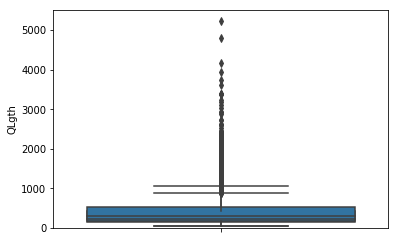

In [154]:
fig = plt.subplots()
sns.boxplot(y=filtered_tmp_df.drop_duplicates('Query')['QLgth'])
sns.boxplot(y=allele_blast_df.drop_duplicates('Query')['QLgth'])
plt.ylim(0, 5500)

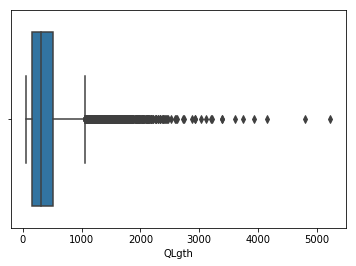

In [146]:
sns.boxplot(allele_blast_df.drop_duplicates('Query')['QLgth'])

In [138]:
import scipy.stats as stats

In [140]:
stats.ranksums(filtered_tmp_df.drop_duplicates('Query')['QLgth'],allele_blast_df.drop_duplicates('Query')['QLgth'] )

RanksumsResult(statistic=-12.95153773667764, pvalue=2.3029423805057582e-38)

In [128]:
#Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

ImportError: No module named 'goatools'

Move on to do some enrichment analysis for GO terms needs to be done 
Looking at the command line this seems all a bit silly.

In [53]:
len(tmp_df_ids)

5067

In [48]:
tmp_df.QCov

0                    93.9597
1                        100
2                    93.1034
3                    80.4598
4                    81.8391
5                    69.1954
6                    78.1609
7                    57.4713
8                     54.023
9                    78.3908
10                   53.7931
11                   82.2989
12                   78.3908
13                   80.9195
14                   54.9425
15                    56.092
16                   68.7356
17                   58.8506
18                   79.5402
19                   53.7931
20                   50.3448
21                   54.9425
22                    77.931
23                   57.0115
24                   52.8736
25                   52.8736
26                   56.5517
27                   51.0345
28                   57.4713
29                   50.5747
                 ...        
189910      12.2568093385214
189911    17.898832684824903
189912     8.365758754863812
189913     8.3

In [41]:
QP_filter = (allele_QC_df.QCov >= QCov_limit) & (allele_QC_df.PctID >= PctID_limit)

,Query,Target,PctID,AlnLgth,NumMis,NumGap,StartQuery,StopQuery,StartTarget,StopTarget,...,primary_contig,pwh_contig,gene_on_genome_blast_hit,exn_asso_contig,exn_no_asso_contig,ph_p_homo_region,Pst_E104_v1_ph_ctg.freebayes_SNP,Pst_E104_v1_ph_ctg.freebayes_SNP_#,Pst_E104_v1_ph_ctg.freebayes_SNP_%,overlap_p_on_h_mapping
0,evm.model.hcontig_000_003.1,evm.model.pcontig_000.2,98.57,140,2,0,1,140,1,140,...,False,False,True,False,0,False,False,0,0.000,False
1,evm.model.hcontig_000_003.10,evm.model.pcontig_000.9,100,57,0,0,1,57,1,57,...,False,False,True,True,0,False,False,0,0.000,False
2,evm.model.hcontig_000_003.101,evm.model.pcontig_000.96,99.51,405,2,0,1,405,1,405,...,False,False,True,False,False,False,False,0,0.000,False
3,evm.model.hcontig_000_003.101,evm.model.pcontig_000.91,49.71,350,128,3,57,406,1,302,...,False,False,True,False,False,False,False,0,0.000,False
4,evm.model.hcontig_000_003.101,evm.model.pcontig_000.92,43.26,356,149,4,57,406,1,309,...,False,False,True,False,False,False,False,0,0.000,False
5,evm.model.hcontig_000_003.101,evm.model.pcontig_019.51,30.23,301,188,7,111,391,18,316,...,False,False,True,False,False,False,False,0,0.000,False
6,evm.model.hcontig_000_003.101,evm.model.pcontig_003.468,29.41,340,166,7,82,389,28,325,...,False,False,True,False,False,False,False,0,0.000,False
7,evm.model.hcontig_000_003.101,evm.model.pcontig_019.48,33.2,250,150,5,157,391,52,299,...,False,False,True,False,False,False,False,0,0.000,False
8,evm.model.hcontig_000_003.101,evm.model.pcontig_003.421,33.19,235,129,3,183,389,88,322,...,False,False,True,False,False,False,False,0,0.000,False
9,evm.model.hcontig_000_003.101,evm.model.pcontig_003.428,30.79,341,165,8,79,389,25,324,...,False,False,True,False,False,False,False,0,0.000,False


In [ ]:
#now a bit more specific for each haplotyp
os.chdir(ALLELE_QC_PATH)
allele_blast_df.head()